In [9]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import sys
model_dir = '/homes/okz21/NNC/models/'
sys.path.append(model_dir)
import models 
from models import test_accuracy, train_epoch

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(color_codes=True)


#Data
train_dataset = dsets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = dsets.MNIST(root='./data', train=False , transform=transforms.ToTensor(), download=True)

num_epochs = 100
batch_size = 256

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
use_cuda = torch.cuda.is_available()

## LeNet 300-100

### 1. Train Model

In [18]:
model = models.LeNet_300_100()
for params in model.parameters():
    print params.size()
    


criterion = nn.CrossEntropyLoss()
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay = 0.0005)

if use_cuda:
    model.cuda()
for epoch in range(num_epochs):
    model, loss = train_epoch(model, optimizer, criterion, train_loader)
    accuracy = test_accuracy(test_loader, model)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], accuracy))

torch.Size([300, 784])
torch.Size([300])
torch.Size([100, 300])
torch.Size([100])
torch.Size([10, 100])
torch.Size([10])
Epoch: 1. Loss: 1.72942698002. Accuracy: 81.38
Epoch: 2. Loss: 1.65629673004. Accuracy: 90.12
Epoch: 3. Loss: 1.56915843487. Accuracy: 91.17
Epoch: 4. Loss: 1.56628882885. Accuracy: 91.82
Epoch: 5. Loss: 1.54540264606. Accuracy: 92.22
Epoch: 6. Loss: 1.57523286343. Accuracy: 92.69
Epoch: 7. Loss: 1.57572555542. Accuracy: 92.83
Epoch: 8. Loss: 1.51517617702. Accuracy: 93.1
Epoch: 9. Loss: 1.55246031284. Accuracy: 93.19
Epoch: 10. Loss: 1.53277826309. Accuracy: 93.57
Epoch: 11. Loss: 1.55683720112. Accuracy: 93.71
Epoch: 12. Loss: 1.5437463522. Accuracy: 93.94
Epoch: 13. Loss: 1.54664266109. Accuracy: 94.1
Epoch: 14. Loss: 1.52948236465. Accuracy: 94.27
Epoch: 15. Loss: 1.51644945145. Accuracy: 94.39
Epoch: 16. Loss: 1.54027843475. Accuracy: 94.53
Epoch: 17. Loss: 1.50062274933. Accuracy: 94.55
Epoch: 18. Loss: 1.5238571167. Accuracy: 94.61
Epoch: 19. Loss: 1.498844623

In [19]:
torch.save(model, model_dir + 'mnist_{}_{}_wd.m'.format(model.name, num_epochs))

### 2. Re-train Model

97.53
97.76


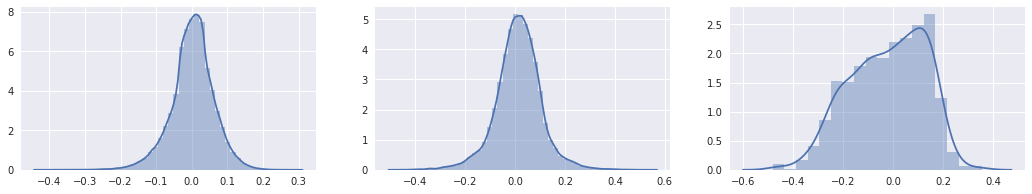

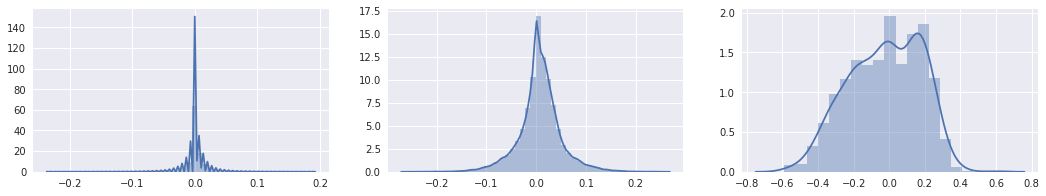

In [7]:
# 1. Load model
# 2. Get new labels, generate new dataset
# 3. New Loss Function
# 4. Freeze Layers
# 5. Train with L2 penalty
# 6. Trim
# 7. Get accuracy

#1
model_name = 'LeNet_300_100'
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model_name, num_epochs))
model_wd = torch.load(model_dir + 'mnist_{}_{}_wd.m'.format(model_name, num_epochs))

print test_accuracy(test_loader, model)
print test_accuracy(test_loader, model_wd)

show_weights(model)
show_weights(model_wd)

In [6]:
def show_weights(model):
    weight_list = ['fc1.weight', 'fc2.weight', 'fc3.weight']
    plt.clf()
    plt.figure(figsize=(18, 3))
    for i,weight in enumerate(weight_list):
        plt.subplot(131 + i)
        fc_w = model.state_dict()[weight]
        sns.distplot(fc_w.view(-1).cpu().numpy())
    plt.show()

class layer_utils():
    def __init__(self, weight):
        self.weight = weight
        self.org_weight = weight.clone()
        self.num_weights = weight.size()[0] * weight.size()[1]
        
        weight_np = np.abs((weight.clone().cpu().numpy()))
        weight_np = weight_np.reshape(-1)
        percentile_limits = [x for x in range (0,101)]
        self.percentile_values = np.percentile(weight_np, percentile_limits)
        
        self.num_pruned = 0
        
    def prune(self, percentile):
        self.weight = self.org_weight.clone()
        zero_idx = self.weight.abs()<self.percentile_values[percentile]
        self.num_pruned = zero_idx.sum()
        self.weight[zero_idx] = 0
        return self.weight
    
    def plot(self):
        plt.clf()
        sns.distplot(self.weight.clone().view(-1).cpu().numpy())
        plt.show()
        
#6. Trimming layers
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs))
result_list = []
for prune_l1 in range(0,101,10):
    L1 = layer_utils(model.fc1.weight.data)
    model.fc1.weight.data = L1.prune(prune_l1)
    L2 = layer_utils(model.fc2.weight.data)
    model.fc2.weight.data = L2.prune(prune_l1)
    L3 = layer_utils(model.fc3.weight.data)
    model.fc3.weight.data = L3.prune(prune_l1)
    accuracy = test_accuracy(test_loader, model)
    print accuracy

97.53
97.46
97.38
97.26
97.47
96.83
93.71
78.24
35.92
18.77
8.92


In [189]:
#2
targets_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=60000, shuffle=False)
for i, (images, labels) in enumerate(targets_loader):
    kd_outputs = model(Variable(images).cuda())

features = torch.zeros(len(train_dataset), train_dataset[0][0].size()[1], train_dataset[0][0].size()[2])
for i in range(0,len(train_dataset)):
    features[i] = train_dataset[i][0][0]
kd_dataset = torch.utils.data.TensorDataset(features, kd_outputs.data)#.data turns variable -> tensor

train_kd_loader = torch.utils.data.DataLoader(dataset=kd_dataset, batch_size=batch_size, shuffle=True)

In [120]:
def freeze_layer(model, layer_n, freeze = True):
    freeze_params = [(layer_n - 1) * 2, (layer_n - 1) * 2 + 1]
    for i,param in enumerate(model.parameters()):
        if i in freeze_params:
            print (param.size(), "frozen" if freeze else "unfrozen")
            param.requires_grad = not freeze


for i,param in enumerate(model.parameters()):
    print param.requires_grad

(torch.Size([500, 1200]), 'unfrozen')
(torch.Size([500]), 'unfrozen')
True
True
True
True
True
True


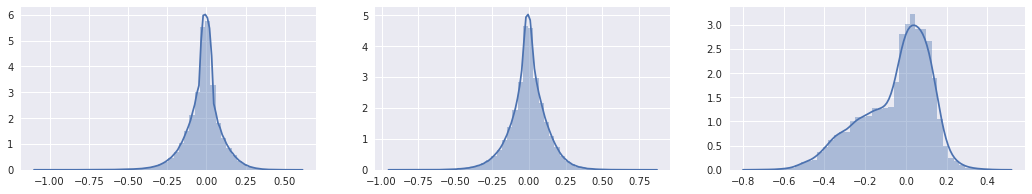

In [202]:
model = torch.load(model_dir + 'mnist_{}_{}.m'.format(model.name, num_epochs))

criterion_kd = nn.MSELoss()
learning_rate_kd = 0.0005
wd_kd = 0.0005
optimizer_kd_1 = torch.optim.Adam(model.fc1.parameters(), lr=learning_rate_kd, weight_decay = wd_kd/2)
optimizer_kd_2 = torch.optim.Adam(model.fc2.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)
optimizer_kd_3 = torch.optim.Adam(model.fc3.parameters(), lr=learning_rate_kd, weight_decay = wd_kd)

show_weights(model)

Epoch: 1. Loss: 1.50343183236e-07. Accuracy: 98.01
Epoch: 2. Loss: 9.37439153859e-07. Accuracy: 98.14
Epoch: 3. Loss: 0.0016266645398. Accuracy: 98.18
Epoch: 4. Loss: 4.64215190732e-05. Accuracy: 98.15
Epoch: 5. Loss: 1.28076662804e-05. Accuracy: 98.24


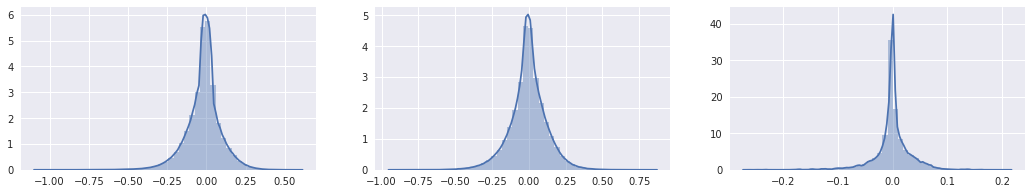

In [203]:
for epoch in range(5):
    model, loss = train_epoch(model, optimizer_kd_3, criterion_kd, train_kd_loader)
    accuracy = test_accuracy(test_loader, model)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], accuracy))
show_weights(model)

Epoch: 1. Loss: 0.000173183580046. Accuracy: 98.24
Epoch: 2. Loss: 0.000108529216959. Accuracy: 98.22
Epoch: 3. Loss: 0.000772106752265. Accuracy: 98.33
Epoch: 4. Loss: 0.00111119507346. Accuracy: 98.43
Epoch: 5. Loss: 0.00324385473505. Accuracy: 98.31


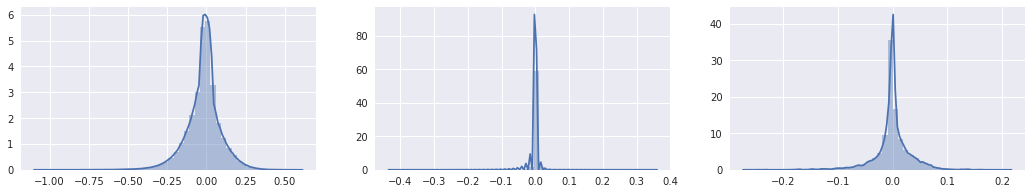

In [204]:
for epoch in range(5):
    model, loss = train_epoch(model, optimizer_kd_2, criterion_kd, train_kd_loader)
    accuracy = test_accuracy(test_loader, model)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], accuracy))
show_weights(model)

Epoch: 1. Loss: 0.00300783733837. Accuracy: 98.18
Epoch: 2. Loss: 0.00504586193711. Accuracy: 97.55
Epoch: 3. Loss: 0.0045603653416. Accuracy: 96.95
Epoch: 4. Loss: 0.00896617397666. Accuracy: 96.24
Epoch: 5. Loss: 0.0110192093998. Accuracy: 95.78


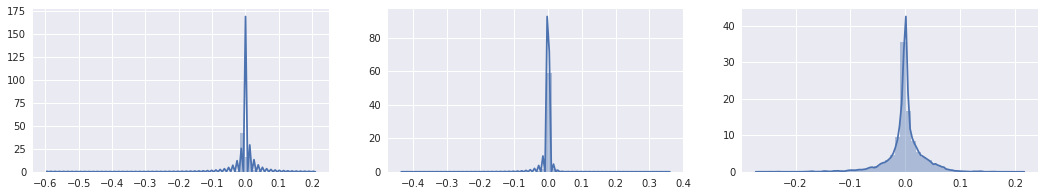

In [205]:
for epoch in range(5):
    model, loss = train_epoch(model, optimizer_kd_1, criterion_kd, train_kd_loader)
    accuracy = test_accuracy(test_loader, model)
    print('Epoch: {}. Loss: {}. Accuracy: {}'.format(epoch+1, loss.data[0], accuracy))
show_weights(model)